# Shapely masking Proof of Concept

Problem (As always...): We don't have a clear way of dealing with the cyclic point in longitude. If I recall correctly, even the natural earth shapefiles just use groups of polygons for features that cross the dateline and represent everything.

The code below doesn't solve this yet.

In [1]:
from climate_index_collection.data_loading import load_data_set

from matplotlib import pyplot as plt

from shapely.geometry import Polygon, Point

import numpy as np
import xarray as xr

In [2]:
ds_FOCI = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")
ds_FOCI

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:                  (lat: 96, lon: 192, time: 120)
Coordinates:
  * lat                      (lat) float64 88.57 86.72 84.86 ... -86.72 -88.57
  * lon                      (lon) float64 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * time                     (time) object 2350-02-15 00:00:00 ... 2360-01-16...
    plev                     float64 5e+04
Data variables:
    sea-surface-salinity     (time, lat, lon) float64 32.08 32.09 ... nan nan
    geopotential-height      (time, lat, lon) float32 ...
    precipitation            (time, lat, lon) float32 ...
    sea-level-pressure       (time, lat, lon) float32 ...
    sea-air-temperature      (time, lat, lon) float32 ...
    sea-surface-temperature  (time, lat, lon) float32 271.4 271.4 ... nan nan
    is_over_ocean            (lat, lon) bool True True True ... False False

In [3]:
NASS_box_lon_lat = Polygon(
    [(-50, 25), (-15, 25), (-15, 50), (-40, 50), (-40, (25+50)//2), (-50, (25+50)//2)]
)

In [4]:
lon_2d, lat_2d = xr.broadcast(ds_FOCI.coords["lon"], ds_FOCI.coords["lat"])
lon_2d = lon_2d % 360 - 360 * ((lon_2d % 360) > 180)

In [5]:
mask = xr.DataArray(
    np.reshape(
        [
            NASS_box_lon_lat.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
        ],
        lon_2d.shape,
    ),
    dims=lon_2d.dims,
    coords=lon_2d.coords,
)

In [6]:
mask.sum()

<xarray.DataArray ()>
array(217)
Coordinates:
    plev     float64 5e+04

In [7]:
NASS_box_lon_lat.contains(Point(-50, 30))

False

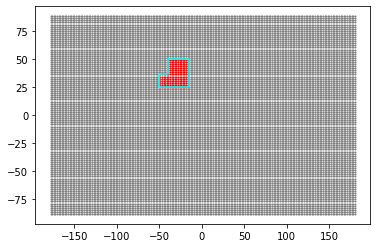

In [8]:
plt.scatter(lon_2d.where(mask), lat_2d.where(mask), s=1, c="r")
plt.scatter(lon_2d.where(~mask), lat_2d.where(~mask), s=1, c="gray")
plt.plot(*NASS_box_lon_lat.exterior.xy, "cyan")